# Reproducing original experiments with KL-CPD

In [54]:
from __future__ import print_function
import argparse
import math
import numpy as np
import os
import random
import sklearn.metrics
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import mmd_util
from data_loader import DataLoader
from optim import Optim

import pickle

In [55]:
class NetG(nn.Module):
    def __init__(self, args, data):
        super(NetG, self).__init__()
        self.wnd_dim = args['wnd_dim']
        self.var_dim = data.var_dim
        self.D = data.D
        self.RNN_hid_dim = args['RNN_hid_dim']

        self.rnn_enc_layer = nn.GRU(self.var_dim, self.RNN_hid_dim, num_layers=1, batch_first=True)
        self.rnn_dec_layer = nn.GRU(self.var_dim, self.RNN_hid_dim, num_layers=1, batch_first=True)
        self.fc_layer = nn.Linear(self.RNN_hid_dim, self.var_dim)

    # X_p:   batch_size x wnd_dim x var_dim (Encoder input)
    # X_f:   batch_size x wnd_dim x var_dim (Decoder input)
    # h_t:   1 x batch_size x RNN_hid_dim
    # noise: 1 x batch_size x RNN_hid_dim
    def forward(self, X_p, X_f, noise):
        X_p_enc, h_t = self.rnn_enc_layer(X_p)
        X_f_shft = self.shft_right_one(X_f)
        hidden = h_t + noise
        Y_f, _ = self.rnn_dec_layer(X_f_shft, hidden)
        output = self.fc_layer(Y_f)
        return output

    def shft_right_one(self, X):
        X_shft = X.clone()
        X_shft[:, 0, :].data.fill_(0)
        X_shft[:, 1:, :] = X[:, :-1, :]
        return X_shft

In [56]:
class NetD(nn.Module):
    def __init__(self, args, data):
        super(NetD, self).__init__()

        self.wnd_dim = args['wnd_dim']
        self.var_dim = data.var_dim
        self.D = data.D
        self.RNN_hid_dim = args['RNN_hid_dim']

        self.rnn_enc_layer = nn.GRU(self.var_dim, self.RNN_hid_dim, batch_first=True)
        self.rnn_dec_layer = nn.GRU(self.RNN_hid_dim, self.var_dim, batch_first=True)

    def forward(self, X):
        X_enc, _ = self.rnn_enc_layer(X)
        X_dec, _ = self.rnn_dec_layer(X_enc)
        return X_enc, X_dec

In [4]:
# Y, L should be numpy array
def valid_epoch(loader, data, netD, batch_size, Y_true, L_true):
    netD.eval()
    Y_pred = []
    for inputs in loader.get_batches(data, batch_size, shuffle=False):
        X_p, X_f = inputs[0], inputs[1]
        batch_size = X_p.size(0)

        X_p_enc, _ = netD(X_p)
        X_f_enc, _ = netD(X_f)
        Y_pred_batch = mmd_util.batch_mmd2_loss(X_p_enc, X_f_enc, sigma_var)
        Y_pred.append(Y_pred_batch.data.cpu().numpy())
        
    Y_pred = np.concatenate(Y_pred, axis=0)

    L_pred = Y_pred
    fp_list, tp_list, thresholds = sklearn.metrics.roc_curve(L_true, L_pred)
    auc = sklearn.metrics.auc(fp_list, tp_list)
    eval_dict = {'Y_pred': Y_pred,
                 'L_pred': L_pred,
                 'Y_true': Y_true,
                 'L_true': L_true,
                 'mse': -1, 'mae': -1, 'auc': auc}
    netD.train()
    return eval_dict

## Passing default arguments as a dict 

In [5]:
args = {}
args['data_path'] = '/home/eromanenkova/Intern_CPD/Alex/new_code/klcpd_code/data/beedance/beedance-2.mat'
args['trn_ratio'] = 0.6
args['val_ratio'] = 0.8
args['gpu'] = 0
args['cuda'] = True
args['random_seed'] = 1126
args['wnd_dim'] = 10
args['sub_dim'] = 1
args['RNN_hid_dim'] = 10
args['batch_size'] = 64
args['max_iter'] = 100
args['optim'] = 'adam'
args['lr'] = 3e-4
args['weight_decay'] = 0.
args['momentum'] = 0.
args['grad_clip'] = 10
args['eval_freq'] = 50
args['CRITIC_ITERS'] = 5
args['weight_clip'] = .1
args['lambda_ae'] = 0.001
args['lambda_real'] = 0.1
args['save_path'] = '/home/eromanenkova/Intern_CPD/Alex/new_code/klcpd_code/models'

In [6]:
args['data_path']

'/home/eromanenkova/Intern_CPD/Alex/new_code/klcpd_code/data/beedance/beedance-2.mat'

In [6]:
if not os.path.exists(args['save_path']):
    os.mkdir(args['save_path'])
assert(os.path.isdir(args['save_path']))
# assert(args.sub_dim == 1)

#XXX For Yahoo dataset, trn_ratio=0.50, val_ratio=0.75
if 'yahoo' in args['data_path']:
    args['trn_ratio'] = 0.50
    args['val_ratio'] = 0.75

# ========= Setup GPU device and fix random seed=========#
if torch.cuda.is_available():
    args['cuda'] = True
    torch.cuda.set_device(args['gpu'])
    print('Using GPU device', torch.cuda.current_device())
else:
    raise EnvironmentError("GPU device not available!")
    
np.random.seed(seed=args['random_seed'])
random.seed(args['random_seed'])
torch.manual_seed(args['random_seed'])
torch.cuda.manual_seed(args['random_seed'])
# [INFO] cudnn.benckmark=True enable cudnn auto-tuner to find the best algorithm to use for your hardware
# [INFO] benchmark mode is good whenever input sizes of network do not vary much!!!
# [INFO] https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
# [INFO] https://discuss.pytorch.org/t/pytorch-performance/3079/2
cudnn.benchmark == True

# [INFO} For reproducibility and debugging, set cudnn.enabled=False
# [INFO] Some operations are non-deterministic when cudnn.enabled=True
# [INFO] https://discuss.pytorch.org/t/non-determinisic-results/459
# [INFO] https://discuss.pytorch.org/t/non-reproducible-result-with-gpu/1831
cudnn.enabled = True

Using GPU device 0


## Look at original data format

In [7]:
import os
import numpy as np
import scipy.io as sio
import math
import torch
from torch.autograd import Variable

class DataLoader(object):
    def __init__(self, args, trn_ratio=0.6, val_ratio=0.8):
        self.cuda = args['cuda']
        #self.cuda = True
        self.data_path = args['data_path']
        self.p_wnd_dim = 25
        self.f_wnd_dim = args['wnd_dim']
        self.sub_dim = args['sub_dim']
        self.batch_size = args['batch_size']

        # load data
        self.load_data(trn_ratio=trn_ratio, val_ratio=val_ratio)

        # prepare data
        self.prepare_data()

        # split data into trn/val/tst set
        self.split_data()

    # load data
    def load_data(self, trn_ratio=0.6, val_ratio=0.8):
        assert(os.path.lexists(self.data_path))
        dataset = sio.loadmat(self.data_path)
        self.Y = dataset['Y']                                   # Y: time series data, time length x number of variables
        self.L = dataset['L']                                   # L: label of anomaly, time length x 1
        self.T, self.D = self.Y.shape                           # T: time length; D: variable dimension
        self.n_trn = int(np.ceil(self.T * trn_ratio))           # n_trn: first index of val set
        self.n_val = int(np.ceil(self.T * val_ratio))           # n_val: first index of tst set
        self.var_dim = self.D * self.sub_dim
        
        return dataset

    # prepare subspace data (Hankel matrix)
    def prepare_data(self):
        # T x D x sub_dim
        self.Y_subspace = np.zeros((self.T, self.D, self.sub_dim))
        for t in range(self.sub_dim, self.T):
            for d in range(self.D):
                self.Y_subspace[t, d, :] = self.Y[t - self.sub_dim + 1 : t + 1, d].flatten()

        # Y_subspace is now T x (D x sub_dim)
        self.Y_subspace = self.Y_subspace.reshape(self.T, -1)
        
        return self.Y_subspace

    # split data into trn/val/tst set
    def split_data(self):
        trn_set_idx = range(self.p_wnd_dim, self.n_trn)
        val_set_idx = range(self.n_trn, self.n_val)
        tst_set_idx = range(self.n_val, self.T)
        print('n_trn ', len(trn_set_idx), 'n_val ', len(val_set_idx), 'n_tst ', len(tst_set_idx))
        self.trn_set = self.__batchify(trn_set_idx)
        self.val_set = self.__batchify(val_set_idx)
        self.tst_set = self.__batchify(tst_set_idx)
        
        return self.trn_set, self.tst_set, self.val_set

    # convert augmented data in Hankel matrix to origin time series
    # input: X_f, whose shape is batch_size x seq_len x (D*sub_dim)
    # output: Y_t, whose shape is batch_size x D
    def repack_data(self, X_f, batch_size):
        Y_t = X_f[:, 0, :].contiguous().view(batch_size, self.D, self.sub_dim)
        return Y_t[:, :, -1]

    def __batchify(self, idx_set):
        n = len(idx_set)
        L = torch.zeros((n, 1))                             # anomaly label
        Y = torch.zeros((n, self.D))                        # true signal
        X_p = torch.zeros((n, self.p_wnd_dim, self.var_dim))  # past window buffer
        X_f = torch.zeros((n, self.f_wnd_dim, self.var_dim))  # future window buffer

        # XXX: dirty trick to augment the last buffer
        data = np.concatenate((self.Y_subspace, self.Y_subspace[-self.f_wnd_dim:, :]))
        for i in range(n):
            l = idx_set[i] - self.p_wnd_dim
            m = idx_set[i]
            u = idx_set[i] + self.f_wnd_dim
            X_p[i, :, :] = torch.from_numpy(data[l:m, :])
            X_f[i, :, :] = torch.from_numpy(data[m:u, :])
            Y[i, :] = torch.from_numpy(self.Y[m, :])
            L[i] = torch.from_numpy(self.L[m])
        return {'X_p': X_p, 'X_f': X_f, 'Y': Y, 'L': L}

    def get_batches(self, data_set, batch_size, shuffle=False):
        X_p, X_f = data_set['X_p'], data_set['X_f']
        Y, L = data_set['Y'], data_set['L']
        length = len(Y)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        s_idx = 0
        while (s_idx < length):
            e_idx = min(length, s_idx + batch_size)
            excerpt = index[s_idx:e_idx]
            X_p_batch, X_f_batch = X_p[excerpt], X_f[excerpt]
            Y_batch, L_batch = Y[excerpt], L[excerpt]
            if self.cuda:
                X_p_batch = X_p_batch.cuda()
                X_f_batch = X_f_batch.cuda()
                Y_batch = Y_batch.cuda()
                L_batch = L_batch.cuda()

            data = [Variable(X_p_batch),
                    Variable(X_f_batch),
                    Variable(Y_batch),
                    Variable(L_batch)]
            yield data
            s_idx += batch_size

In [38]:
Data = DataLoader(args=args, trn_ratio=args['trn_ratio'], val_ratio=args['val_ratio'])

n_trn  650 n_val  225 n_tst  224


In [39]:
loaded_dataset = Data.load_data()

In [40]:
print('initial seq (Y):', loaded_dataset['Y'])
loaded_dataset['Y'].shape

initial seq (Y): [[0.46881138 0.24722328 0.59424341]
 [0.47624722 0.24586509 0.53681638]
 [0.47491192 0.19903185 0.51054309]
 ...
 [0.22467969 0.54632052 0.28420598]
 [0.25351394 0.51194649 0.80778465]
 [0.26821072 0.56950183 0.44725902]]


(1124, 3)

"Fishkiller": 

    'Y' - 1 sequence with 1D-observations, length T=45175, shape=(45175, 1)
    'L' - corresponding labels, shape=(45175, 1)

In [44]:
print('initial labels (L):',loaded_dataset['L'])
loaded_dataset['L'].shape

initial labels (L): [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


(1124, 1)

In [13]:
np.where(loaded_dataset['L'].squeeze() == 1)

(array([  47,  100,  160,  209,  265,  337,  370,  416,  449,  494,  550,
         594,  636,  671,  713,  778,  834,  890,  942,  986, 1045, 1106]),)

In [41]:
# prepare data
Y_subspace = Data.prepare_data()

In [42]:
Y_subspace.shape # Y_subspace has the same shape (initial seq_len, subspace_dim)

(1124, 3)

In [23]:
print(Y_subspace)

[[ 0.        ]
 [ 0.        ]
 [-0.87493411]
 ...
 [82.41881436]
 [80.94807863]
 [78.80273557]]


In [43]:
trn_set, tst_set, val_set = Data.split_data()

n_trn  650 n_val  225 n_tst  224


In [44]:
trn_set['X_p'].size()

torch.Size([650, 25, 3])

In [45]:
trn_set['X_f'].size()

torch.Size([650, 10, 3])

In [53]:
trn_set['Y'].size()

torch.Size([650, 3])

In [47]:
trn_set['L'].size()

torch.Size([650, 1])

## Get DataLoader and the nets

In [48]:
Data = DataLoader(args=args, trn_ratio=args['trn_ratio'], val_ratio=args['val_ratio'])
netG = NetG(args, Data)
netD = NetD(args, Data)

n_trn  650 n_val  225 n_tst  224


In [49]:
Data.trn_set['X_p'].size()

torch.Size([650, 25, 3])

In [50]:
Data.trn_set['X_f'].size()

torch.Size([650, 10, 3])

In [57]:
#Data.trn_set['L']

In [11]:
if args['cuda']:
    netG.cuda()
    netD.cuda()
    
netG_params_count = sum([p.nelement() for p in netG.parameters()])
netD_params_count = sum([p.nelement() for p in netD.parameters()])
print(netG)
print(netD)
print('netG has number of parameters: %d' % (netG_params_count))
print('netD has number of parameters: %d' % (netD_params_count))
one = torch.tensor(1, dtype=torch.float)

mone = one * -1

NetG(
  (rnn_enc_layer): GRU(3, 10, batch_first=True)
  (rnn_dec_layer): GRU(3, 10, batch_first=True)
  (fc_layer): Linear(in_features=10, out_features=3, bias=True)
)
NetD(
  (rnn_enc_layer): GRU(3, 10, batch_first=True)
  (rnn_dec_layer): GRU(10, 3, batch_first=True)
)
netG has number of parameters: 933
netD has number of parameters: 585


In [12]:
optimizerG = Optim(netG.parameters(),
                   'adam',
                   lr=3e-4,
                   grad_clip=10.0,
                   weight_decay=0.,
                   momentum=0.0)

optimizerD = Optim(netD.parameters(),
                   'adam',
                   lr=3e-4,
                   grad_clip=10.0,
                   weight_decay=0.,
                   momentum=0.0)

In [13]:
sigma_list = mmd_util.median_heuristic(Data.Y_subspace, beta=.5)
sigma_var = torch.cuda.FloatTensor(sigma_list)
print('sigma_var:', sigma_var)

sigma_var: tensor([0.0476, 0.0952, 0.1904, 0.3808, 0.7615], device='cuda:0')


In [14]:
# ========= Main loop for adversarial training kernel with negative samples X_f + noise =========#
Y_val = Data.val_set['Y'].numpy()
L_val = Data.val_set['L'].numpy()
Y_tst = Data.tst_set['Y'].numpy()
L_tst = Data.tst_set['L'].numpy()

n_batchs = int(math.ceil(len(Data.trn_set['Y']) / float(args['batch_size'])))
print('n_batchs', n_batchs, 'batch_size', args['batch_size'])

lambda_ae = args['lambda_ae']
lambda_real = args['lambda_real']
gen_iterations = 0
total_time = 0.
best_epoch = -1
best_val_mae = 1e+6
best_val_auc = -1
best_tst_auc = -1
best_mmd_real = 1e+6
start_time = time.time()

n_batchs 11 batch_size 64


In [24]:
print('start training: lambda_ae', lambda_ae, 'lambda_real', lambda_real, 'weight_clip', args['weight_clip'])

for epoch in range(1, args['max_iter'] + 1):
#while(best_mmd_real > 1e-4):
    trn_loader = Data.get_batches(Data.trn_set, batch_size=args['batch_size'], shuffle=True)
    bidx = 0
    while bidx < n_batchs:
        ############################
        # (1) Update D network
        ############################
        for p in netD.parameters():
            p.requires_grad = True

        for diters in range(args['CRITIC_ITERS']):
            # clamp parameters of NetD encoder to a cube
            for p in netD.rnn_enc_layer.parameters():
                p.data.clamp_(-args['weight_clip'], args['weight_clip'])
            if bidx == n_batchs:
                break

            inputs = next(trn_loader)
            X_p, X_f, Y_true = inputs[0], inputs[1], inputs[2]
            batch_size = X_p.size(0)
            bidx += 1

            # real data
            X_p_enc, X_p_dec = netD(X_p)
            X_f_enc, X_f_dec = netD(X_f)

            # fake data
            noise = torch.cuda.FloatTensor(1, batch_size, args['RNN_hid_dim']).normal_(0, 1) # брал cuda
            noise = Variable(noise, volatile=True) # total freeze netG
            Y_f = Variable(netG(X_p, X_f, noise).data)
            Y_f_enc, Y_f_dec = netD(Y_f)

            # batchwise MMD2 loss between X_f and Y_f
            D_mmd2 = mmd_util.batch_mmd2_loss(X_f_enc, Y_f_enc, sigma_var)

            # batchwise MMD2 loss between X_f and Y_f
            mmd2_real = mmd_util.batch_mmd2_loss(X_p_enc, X_f_enc, sigma_var)

            # reconstruction loss
            real_L2_loss = torch.mean((X_f - X_f_dec)**2)
            #real_L2_loss = torch.mean((X_p - X_p_dec)**2)
            fake_L2_loss = torch.mean((Y_f - Y_f_dec)**2)
            #fake_L2_loss = torch.mean((Y_f - Y_f_dec)**2) * 0.0

            # update netD
            netD.zero_grad()
            lossD = D_mmd2.mean() - lambda_ae * (real_L2_loss + fake_L2_loss) - lambda_real * mmd2_real.mean()
            #lossD = 0.0 * D_mmd2.mean() - lambda_ae * (real_L2_loss + fake_L2_loss) - lambda_real * mmd2_real.mean()
            #lossD = -real_L2_loss
            lossD.backward(mone)
            optimizerD.step()

        ############################
        # (2) Update G network
        ############################
        for p in netD.parameters():
            p.requires_grad = False  # to avoid computation

        if bidx == n_batchs:
            break

        inputs = next(trn_loader)
        X_p, X_f = inputs[0], inputs[1]
        batch_size = X_p.size(0)
        bidx += 1

        # real data
        X_f_enc, X_f_dec = netD(X_f)

        # fake data
        noise = torch.cuda.FloatTensor(1, batch_size, args['RNN_hid_dim']).normal_(0, 1) # убрал cuda
        noise = Variable(noise)
        Y_f = netG(X_p, X_f, noise)
        Y_f_enc, Y_f_dec = netD(Y_f)

        # batchwise MMD2 loss between X_f and Y_f
        G_mmd2 = mmd_util.batch_mmd2_loss(X_f_enc, Y_f_enc, sigma_var)

        # update netG
        netG.zero_grad()
        lossG = G_mmd2.mean()
        #lossG = 0.0 * G_mmd2.mean()
        lossG.backward(one)
        optimizerG.step()

        #G_mmd2 = Variable(torch.FloatTensor(batch_size).zero_())
        gen_iterations += 1

        #print('D_mmd2:', D_mmd2.mean().item())

        print('[%5d/%5d] [%5d/%5d] [%6d] D_mmd2 %.4e G_mmd2 %.4e mmd2_real %.4e real_L2 %.6f fake_L2 %.6f'
              % (epoch, args['max_iter'], bidx, n_batchs, gen_iterations,
                 D_mmd2.mean().item(), G_mmd2.mean().item(), mmd2_real.mean().item(),
                 real_L2_loss.item(), fake_L2_loss.item()))

        if gen_iterations % args['eval_freq'] == 0:
            # ========= Main block for evaluate MMD(X_p_enc, X_f_enc) on RNN codespace  =========#
            val_dict = valid_epoch(Data, Data.val_set, netD, args['batch_size'], Y_val, L_val)
            tst_dict = valid_epoch(Data, Data.tst_set, netD, args['batch_size'], Y_tst, L_tst)
            total_time = time.time() - start_time
            print('iter %4d tm %4.2fm val_mse %.1f val_mae %.1f val_auc %.6f'
                    % (epoch, total_time / 60.0, val_dict['mse'], val_dict['mae'], val_dict['auc']), end='')

            print (" tst_mse %.1f tst_mae %.1f tst_auc %.6f" % (tst_dict['mse'], tst_dict['mae'], tst_dict['auc']), end='')

            assert(np.isnan(val_dict['auc']) != True)
            #if val_dict['auc'] > best_val_auc:
            #if val_dict['auc'] > best_val_auc and mmd2_real.mean().data[0] < best_mmd_real:
            if mmd2_real.mean().item() < best_mmd_real:
                best_mmd_real = mmd2_real.mean().item()
                best_val_mae = val_dict['mae']
                best_val_auc = val_dict['auc']
                best_tst_auc = tst_dict['auc']
                best_epoch = epoch
                save_pred_name = '%s/pred.pkl' % (args['save_path'])
                with open(save_pred_name, 'wb') as f:
                    pickle.dump(tst_dict, f)
                torch.save(netG.state_dict(), '%s/netG.pkl' % (args['save_path']))
                torch.save(netD.state_dict(), '%s/netD.pkl' % (args['save_path']))
            print(" [best_val_auc %.6f best_tst_auc %.6f best_epoch %3d]" % (best_val_auc, best_tst_auc, best_epoch))

        # stopping condition
        #if best_mmd_real < 1e-4:
        #if mmd2_real.mean().item() < 1e-5:
        #    exit(0)

start training: lambda_ae 0.001 lambda_real 0.1 weight_clip 0.1


/home/eromanenkova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[    1/  100] [    6/   11] [     1] D_mmd2 3.9696e+00 G_mmd2 4.0587e+00 mmd2_real 8.8606e-01 real_L2 0.250475 fake_L2 0.154572
[    2/  100] [    6/   11] [     2] D_mmd2 4.1227e+00 G_mmd2 4.0589e+00 mmd2_real 9.3354e-01 real_L2 0.258504 fake_L2 0.137592
[    3/  100] [    6/   11] [     3] D_mmd2 4.2668e+00 G_mmd2 4.1920e+00 mmd2_real 8.6151e-01 real_L2 0.275639 fake_L2 0.134515
[    4/  100] [    6/   11] [     4] D_mmd2 4.2493e+00 G_mmd2 4.3544e+00 mmd2_real 8.2608e-01 real_L2 0.264977 fake_L2 0.125769
[    5/  100] [    6/   11] [     5] D_mmd2 4.4375e+00 G_mmd2 4.3762e+00 mmd2_real 8.6682e-01 real_L2 0.284731 fake_L2 0.125974
[    6/  100] [    6/   11] [     6] D_mmd2 4.4675e+00 G_mmd2 4.5475e+00 mmd2_real 7.7431e-01 real_L2 0.268523 fake_L2 0.116267
[    7/  100] [    6/   11] [     7] D_mmd2 4.5477e+00 G_mmd2 4.5831e+00 mmd2_real 7.4282e-01 real_L2 0.273850 fake_L2 0.113549
[    8/  100] [    6/   11] [     8] D_mmd2 4.7803e+00 G_mmd2 4.7788e+00 mmd2_real 7.1175e-01 real_L2 0.

/home/eromanenkova/Intern_CPD/Alex/new_code/klcpd_code/mmd_util.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sigma_samples = F.softmax(U * gumbel_lmd).matmul(sigma_var)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/eromanenkova/Intern_CPD/Alex/new_code/klcpd_code/mmd_util.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sigma_samples = F.softmax(U * gumbel_lmd).matmul(sigma_var)


iter   50 tm 10.19m val_mse -1.0 val_mae -1.0 val_auc 0.557692 tst_mse -1.0 tst_mae -1.0 tst_auc 0.463636 [best_val_auc 0.557692 best_tst_auc 0.463636 best_epoch  50]
[   51/  100] [    6/   11] [    51] D_mmd2 5.7565e+00 G_mmd2 5.8559e+00 mmd2_real 6.8705e-01 real_L2 0.172274 fake_L2 0.038226
[   52/  100] [    6/   11] [    52] D_mmd2 5.7777e+00 G_mmd2 5.7673e+00 mmd2_real 6.0610e-01 real_L2 0.169621 fake_L2 0.039980
[   53/  100] [    6/   11] [    53] D_mmd2 5.8289e+00 G_mmd2 5.7512e+00 mmd2_real 6.9237e-01 real_L2 0.161879 fake_L2 0.036902
[   54/  100] [    6/   11] [    54] D_mmd2 5.7577e+00 G_mmd2 5.7671e+00 mmd2_real 7.3265e-01 real_L2 0.162559 fake_L2 0.033637
[   55/  100] [    6/   11] [    55] D_mmd2 5.9070e+00 G_mmd2 5.8920e+00 mmd2_real 7.8208e-01 real_L2 0.161554 fake_L2 0.034705
[   56/  100] [    6/   11] [    56] D_mmd2 5.8005e+00 G_mmd2 5.8301e+00 mmd2_real 6.8453e-01 real_L2 0.144357 fake_L2 0.036829
[   57/  100] [    6/   11] [    57] D_mmd2 5.9469e+00 G_mmd2 5.8

/home/eromanenkova/Intern_CPD/Alex/new_code/klcpd_code/mmd_util.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sigma_samples = F.softmax(U * gumbel_lmd).matmul(sigma_var)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/eromanenkova/Intern_CPD/Alex/new_code/klcpd_code/mmd_util.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sigma_samples = F.softmax(U * gumbel_lmd).matmul(sigma_var)


## Try evaluating

In [ ]:
# Y, L should be numpy array
'''
def valid_epoch(loader, data, netD, batch_size, Y_true, L_true):
    netD.eval()
    Y_pred = []
    for inputs in loader.get_batches(data, batch_size, shuffle=False):
        X_p, X_f = inputs[0], inputs[1]
        batch_size = X_p.size(0)

        X_p_enc, _ = netD(X_p)
        X_f_enc, _ = netD(X_f)
        Y_pred_batch = mmd_util.batch_mmd2_loss(X_p_enc, X_f_enc, sigma_var)
        Y_pred.append(Y_pred_batch.data.cpu().numpy())
    Y_pred = np.concatenate(Y_pred, axis=0)

    L_pred = Y_pred
    fp_list, tp_list, thresholds = sklearn.metrics.roc_curve(L_true, L_pred)
    auc = sklearn.metrics.auc(fp_list, tp_list)
    eval_dict = {'Y_pred': Y_pred,
                 'L_pred': L_pred,
                 'Y_true': Y_true,
                 'L_true': L_true,
                 'mse': -1, 'mae': -1, 'auc': auc}
    netD.train()
    return eval_dict
'''

In [25]:
tst_dict = valid_epoch(Data, Data.tst_set, netD, args['batch_size'], Y_tst, L_tst)

In [30]:
pred = tst_dict['Y_pred']

In [37]:
pred

array([1.3198833 , 0.9263717 , 0.9550988 , 1.2123823 , 0.70658636,
       0.8189267 , 0.6951982 , 0.59443116, 0.7179463 , 0.576398  ,
       0.7867337 , 0.81778646, 0.6987508 , 0.5895537 , 0.8825915 ,
       0.5416032 , 0.5967457 , 0.85930073, 0.6648186 , 0.7869399 ,
       0.8073334 , 1.3046923 , 1.0588747 , 0.96216416, 0.6746737 ,
       0.92985415, 0.936676  , 0.9073333 , 1.1053972 , 0.8175859 ,
       1.1539639 , 1.0403857 , 1.4272169 , 1.1721958 , 1.4914905 ,
       1.1718202 , 1.239691  , 1.4163982 , 1.5531106 , 1.732186  ,
       1.5711713 , 1.6407499 , 1.7064996 , 1.623909  , 1.1503116 ,
       1.1967565 , 1.388103  , 1.48285   , 1.4674764 , 1.0193081 ,
       0.73134327, 0.64401203, 0.5747048 , 0.56050277, 0.4581817 ,
       0.32509428, 0.21283194, 0.14070709, 0.14137138, 0.16090584,
       0.1608504 , 0.19873562, 0.25129342, 0.32127962, 0.43185693,
       0.53310513, 0.6186771 , 0.5723858 , 0.70420706, 0.91390157,
       1.2645519 , 1.5048811 , 1.8056793 , 2.052476  , 2.15470

In [35]:
Data.tst_set['Y'].size()

torch.Size([224, 3])

In [35]:
pred = tst_dict['L_pred'].flatten().tolist()

In [36]:
true = L_tst.flatten().tolist()

In [27]:
import matplotlib.pyplot as plt

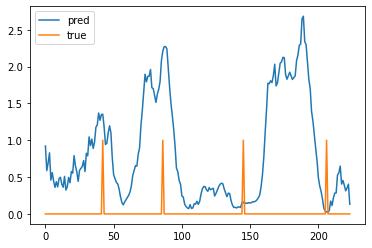

In [37]:
plt.figure()
plt.plot(pred, label='pred')
plt.plot(true, label='true')
plt.legend()

In [42]:
true_indexes = np.where(L_tst.flatten() == 1)
true_indexes

(array([ 42,  86, 145, 206]),)

In [43]:
from scipy.signal import find_peaks

In [46]:
pred_indexes = find_peaks(tst_dict['L_pred'].flatten(), height=1.25, distance=10)
pred_indexes[0]

array([ 41,  77,  88, 173, 189])

In [ ]:
fp_list, tp_list, thresholds = sklearn.metrics.roc_curve(true, pred)

In [ ]:
fp_list

## Converting our synthetic sequences into this format

In [8]:
def labels2indexes(labels_seq):
    cp_indexes = []
    last_label_type = labels_seq[0]
    for i in range(len(labels_seq) - 1):
        if labels_seq[i+1] != last_label_type:
            cp_indexes.append(i+1)
            last_label_type = labels_seq[i+1]
    
    if not cp_indexes:
        cp_indexes = [-1]
    return cp_indexes

def indexes2labels(cp_indexes, seq_len):
    labels_seq = np.array([])
    cp_indexes = cp_indexes + [seq_len]
    start = 0
    for i in range(len(cp_indexes)):
        end = cp_indexes[i] - 1
        segm_len = end - start + 1
    
        if i % 2 == 0:
            labels_segm = np.zeros(segm_len)
        else:
            labels_segm = np.ones(segm_len)
            
        labels_seq = np.append(labels_seq, labels_segm)
        start = end + 1
    return labels_seq

In [9]:
from CPD import datasets, models

In [10]:
test_dataset_1D = datasets.SyntheticNormalDataset(seq_len=128, num=300, D=1)

In [11]:
abnormal_index = 0
normal_index = 200

abnormal_seq = test_dataset_1D.data[abnormal_index]
abnormal_true_labels = test_dataset_1D.labels[abnormal_index]

normal_seq = test_dataset_1D.data[normal_index]
normal_true_labels = test_dataset_1D.labels[normal_index]

In [12]:
abnormal_seq.numpy().shape # shape is ok

(128, 1)

In [13]:
abnormal_true_indexes = labels2indexes(abnormal_true_labels)
new_abnormal_true_indexes = np.zeros(128)
new_abnormal_true_indexes[abnormal_true_indexes] = 1.
new_abnormal_true_indexes

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
new_abnormal_true_indexes = new_abnormal_true_indexes.reshape(128, 1)
#new_abnormal_true_indexes

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [15]:
our_loaded_dataset = {}
our_loaded_dataset['Y'] = abnormal_seq.numpy()
our_loaded_dataset['L'] = new_abnormal_true_indexes

In [16]:
class OurDataLoader(object):
    def __init__(self, args, seq, labels, trn_ratio=0.6, val_ratio=0.8):
        #self.cuda = args['cuda']
        self.cuda = True
        #self.data_path = args['data_path']
        self.p_wnd_dim = 25
        self.f_wnd_dim = args['wnd_dim']
        self.sub_dim = args['sub_dim']
        self.batch_size = args['batch_size']
        self.Y = seq
        self.L = labels

        # load data
        self.load_data(trn_ratio=trn_ratio, val_ratio=val_ratio)

        # prepare data
        self.prepare_data()

        # split data into trn/val/tst set
        self.split_data()

    # load data
    def load_data(self, trn_ratio=0.6, val_ratio=0.8):
        '''
        assert(os.path.lexists(self.data_path))
        dataset = sio.loadmat(self.data_path)
        self.Y = dataset['Y']                                   # Y: time series data, time length x number of variables
        self.L = dataset['L']                                   # L: label of anomaly, time length x 1
        self.T, self.D = self.Y.shape                           # T: time length; D: variable dimension
        self.n_trn = int(np.ceil(self.T * trn_ratio))           # n_trn: first index of val set
        self.n_val = int(np.ceil(self.T * val_ratio))           # n_val: first index of tst set
        self.var_dim = self.D * self.sub_dim
        
        return dataset
        '''
        dataset = {}
        dataset['Y'] = self.Y
        dataset['L'] = self.L
        self.T, self.D = self.Y.shape
        self.n_trn = int(np.ceil(self.T * trn_ratio))           # n_trn: first index of val set
        self.n_val = int(np.ceil(self.T * val_ratio))           # n_val: first index of tst set
        self.var_dim = self.D * self.sub_dim
        
        return dataset

    # prepare subspace data (Hankel matrix)
    def prepare_data(self):
        # T x D x sub_dim
        self.Y_subspace = np.zeros((self.T, self.D, self.sub_dim))
        for t in range(self.sub_dim, self.T):
            for d in range(self.D):
                self.Y_subspace[t, d, :] = self.Y[t - self.sub_dim + 1 : t + 1, d].flatten()

        # Y_subspace is now T x (D x sub_dim)
        self.Y_subspace = self.Y_subspace.reshape(self.T, -1)
        
        return self.Y_subspace

    # split data into trn/val/tst set
    def split_data(self):
        trn_set_idx = range(self.p_wnd_dim, self.n_trn)
        val_set_idx = range(self.n_trn, self.n_val)
        tst_set_idx = range(self.n_val, self.T)
        print('n_trn ', len(trn_set_idx), 'n_val ', len(val_set_idx), 'n_tst ', len(tst_set_idx))
        self.trn_set = self.__batchify(trn_set_idx)
        self.val_set = self.__batchify(val_set_idx)
        self.tst_set = self.__batchify(tst_set_idx)
        
        return self.trn_set, self.tst_set, self.val_set

    # convert augmented data in Hankel matrix to origin time series
    # input: X_f, whose shape is batch_size x seq_len x (D*sub_dim)
    # output: Y_t, whose shape is batch_size x D
    def repack_data(self, X_f, batch_size):
        Y_t = X_f[:, 0, :].contiguous().view(batch_size, self.D, self.sub_dim)
        return Y_t[:, :, -1]

    def __batchify(self, idx_set):
        n = len(idx_set)
        L = torch.zeros((n, 1))                             # anomaly label
        Y = torch.zeros((n, self.D))                        # true signal
        X_p = torch.zeros((n, self.p_wnd_dim, self.var_dim))  # past window buffer
        X_f = torch.zeros((n, self.f_wnd_dim, self.var_dim))  # future window buffer

        # XXX: dirty trick to augment the last buffer
        data = np.concatenate((self.Y_subspace, self.Y_subspace[-self.f_wnd_dim:, :]))
        for i in range(n):
            l = idx_set[i] - self.p_wnd_dim
            m = idx_set[i]
            u = idx_set[i] + self.f_wnd_dim
            X_p[i, :, :] = torch.from_numpy(data[l:m, :])
            X_f[i, :, :] = torch.from_numpy(data[m:u, :])
            Y[i, :] = torch.from_numpy(self.Y[m, :])
            L[i] = torch.from_numpy(self.L[m])
        return {'X_p': X_p, 'X_f': X_f, 'Y': Y, 'L': L}

    def get_batches(self, data_set, batch_size, shuffle=False):
        X_p, X_f = data_set['X_p'], data_set['X_f']
        Y, L = data_set['Y'], data_set['L']
        length = len(Y)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        s_idx = 0
        while (s_idx < length):
            e_idx = min(length, s_idx + batch_size)
            excerpt = index[s_idx:e_idx]
            X_p_batch, X_f_batch = X_p[excerpt], X_f[excerpt]
            Y_batch, L_batch = Y[excerpt], L[excerpt]
            if self.cuda:
                X_p_batch = X_p_batch.cuda()
                X_f_batch = X_f_batch.cuda()
                Y_batch = Y_batch.cuda()
                L_batch = L_batch.cuda()

            data = [Variable(X_p_batch),
                    Variable(X_f_batch),
                    Variable(Y_batch),
                    Variable(L_batch)]
            yield data
            s_idx += batch_size

In [17]:
our_1D_Data = OurDataLoader(seq=abnormal_seq.numpy(),
                            labels=new_abnormal_true_indexes,
                            args=args,
                            trn_ratio=args['trn_ratio'],
                            val_ratio=args['val_ratio'])

n_trn  52 n_val  26 n_tst  25


In [18]:
our_1D_Data.trn_set['X_p'].size()

torch.Size([52, 25, 1])

In [19]:
our_1D_Data.trn_set['X_f'].size()

torch.Size([52, 10, 1])

In [20]:
netG = NetG(args, our_1D_Data)
netD = NetD(args, our_1D_Data)

In [21]:
if args['cuda']:
    netG.cuda()
    netD.cuda()
    
netG_params_count = sum([p.nelement() for p in netG.parameters()])
netD_params_count = sum([p.nelement() for p in netD.parameters()])
print(netG)
print(netD)
print('netG has number of parameters: %d' % (netG_params_count))
print('netD has number of parameters: %d' % (netD_params_count))
one = torch.tensor(1, dtype=torch.float)

mone = one * -1

NetG(
  (rnn_enc_layer): GRU(1, 10, batch_first=True)
  (rnn_dec_layer): GRU(1, 10, batch_first=True)
  (fc_layer): Linear(in_features=10, out_features=1, bias=True)
)
NetD(
  (rnn_enc_layer): GRU(1, 10, batch_first=True)
  (rnn_dec_layer): GRU(10, 1, batch_first=True)
)
netG has number of parameters: 791
netD has number of parameters: 429


In [22]:
optimizerG = Optim(netG.parameters(),
                   'adam',
                   lr=3e-4,
                   grad_clip=10.0,
                   weight_decay=0.,
                   momentum=0.0)

optimizerD = Optim(netD.parameters(),
                   'adam',
                   lr=3e-4,
                   grad_clip=10.0,
                   weight_decay=0.,
                   momentum=0.0)

In [26]:
sigma_list = mmd_util.median_heuristic(our_1D_Data.Y_subspace, beta=.5)
sigma_var = torch.FloatTensor(sigma_list).cuda()
print('sigma_list:', sigma_var)

# ========= Main loop for adversarial training kernel with negative samples X_f + noise =========#
Y_val = our_1D_Data.val_set['Y'].numpy()
L_val = our_1D_Data.val_set['L'].numpy()
Y_tst = our_1D_Data.tst_set['Y'].numpy()
L_tst = our_1D_Data.tst_set['L'].numpy()

n_batchs = int(math.ceil(len(our_1D_Data.trn_set['Y']) / float(args['batch_size'])))
print('n_batchs', n_batchs, 'batch_size', args['batch_size'])

lambda_ae = args['lambda_ae']
lambda_real = args['lambda_real']
gen_iterations = 0
total_time = 0.
best_epoch = -1
best_val_mae = 1e+6
best_val_auc = -1
best_tst_auc = -1
best_mmd_real = 1e+6
start_time = time.time()

sigma_list: tensor([ 1.4390,  2.8780,  5.7560, 11.5119, 23.0239], device='cuda:0')
n_batchs 1 batch_size 128


In [29]:
print('start training: lambda_ae', lambda_ae, 'lambda_real', lambda_real, 'weight_clip', args['weight_clip'])

for epoch in range(1, args['max_iter'] + 1):
#while(best_mmd_real > 1e-4):
    trn_loader = our_1D_Data.get_batches(our_1D_Data.trn_set, batch_size=args['batch_size'], shuffle=True)
    bidx = 0
    while bidx < n_batchs:
        ############################
        # (1) Update D network
        ############################
        for p in netD.parameters():
            p.requires_grad = True

        for diters in range(args['CRITIC_ITERS']):
            # clamp parameters of NetD encoder to a cube
            for p in netD.rnn_enc_layer.parameters():
                p.data.clamp_(-args['weight_clip'], args['weight_clip'])
            if bidx == n_batchs:
                break

            inputs = next(trn_loader)
            X_p, X_f, Y_true = inputs[0], inputs[1], inputs[2]
            batch_size = X_p.size(0)
            bidx += 1

            # real data
            X_p_enc, X_p_dec = netD(X_p)
            X_f_enc, X_f_dec = netD(X_f)

            # fake data
            noise = torch.cuda.FloatTensor(1, batch_size, args['RNN_hid_dim']).normal_(0, 1)
            noise = Variable(noise, volatile=True) # total freeze netG
            Y_f = Variable(netG(X_p, X_f, noise).data)
            Y_f_enc, Y_f_dec = netD(Y_f)

            # batchwise MMD2 loss between X_f and Y_f
            D_mmd2 = mmd_util.batch_mmd2_loss(X_f_enc, Y_f_enc, sigma_var)

            # batchwise MMD loss between X_p and X_f
            mmd2_real = mmd_util.batch_mmd2_loss(X_p_enc, X_f_enc, sigma_var)

            # reconstruction loss
            real_L2_loss = torch.mean((X_f - X_f_dec)**2)
            #real_L2_loss = torch.mean((X_p - X_p_dec)**2)
            fake_L2_loss = torch.mean((Y_f - Y_f_dec)**2)
            #fake_L2_loss = torch.mean((Y_f - Y_f_dec)**2) * 0.0

            # update netD
            netD.zero_grad()
            lossD = D_mmd2.mean() - lambda_ae * (real_L2_loss + fake_L2_loss) - lambda_real * mmd2_real.mean()
            #lossD = 0.0 * D_mmd2.mean() - lambda_ae * (real_L2_loss + fake_L2_loss) - lambda_real * mmd2_real.mean()
            #lossD = -real_L2_loss
            lossD.backward(mone)
            optimizerD.step()

        ############################
        # (2) Update G network
        ############################
        for p in netD.parameters():
            p.requires_grad = False  # to avoid computation

        if bidx == n_batchs:
            break

        inputs = next(trn_loader)
        X_p, X_f = inputs[0], inputs[1]
        batch_size = X_p.size(0)
        bidx += 1

        # real data
        X_f_enc, X_f_dec = netD(X_f)

        # fake data
        noise = torch.cuda.FloatTensor(1, batch_size, args['RNN_hid_dim']).normal_(0, 1)
        noise = Variable(noise)
        Y_f = netG(X_p, X_f, noise)
        Y_f_enc, Y_f_dec = netD(Y_f)

        # batchwise MMD2 loss between X_f and Y_f
        G_mmd2 = mmd_util.batch_mmd2_loss(X_f_enc, Y_f_enc, sigma_var)

        # update netG
        netG.zero_grad()
        lossG = G_mmd2.mean()
        #lossG = 0.0 * G_mmd2.mean()
        lossG.backward(one)
        optimizerG.step()

        #G_mmd2 = Variable(torch.FloatTensor(batch_size).zero_())
        gen_iterations += 1

        #print('D_mmd2:', D_mmd2.mean().item())

        print('[%5d/%5d] [%5d/%5d] [%6d] D_mmd2 %.4e G_mmd2 %.4e mmd2_real %.4e real_L2 %.6f fake_L2 %.6f'
              % (epoch, args['max_iter'], bidx, n_batchs, gen_iterations,
                 D_mmd2.mean().item(), G_mmd2.mean().item(), mmd2_real.mean().item(),
                 real_L2_loss.item(), fake_L2_loss.item()))

        if gen_iterations % args['eval_freq'] == 0:
            # ========= Main block for evaluate MMD(X_p_enc, X_f_enc) on RNN codespace  =========#
            val_dict = valid_epoch(Data, Data.val_set, netD, args['batch_size'], Y_val, L_val)
            tst_dict = valid_epoch(Data, Data.tst_set, netD, args['batch_size'], Y_tst, L_tst)
            total_time = time.time() - start_time
            print('iter %4d tm %4.2fm val_mse %.1f val_mae %.1f val_auc %.6f'
                    % (epoch, total_time / 60.0, val_dict['mse'], val_dict['mae'], val_dict['auc']), end='')

            print (" tst_mse %.1f tst_mae %.1f tst_auc %.6f" % (tst_dict['mse'], tst_dict['mae'], tst_dict['auc']), end='')

            assert(np.isnan(val_dict['auc']) != True)
            #if val_dict['auc'] > best_val_auc:
            #if val_dict['auc'] > best_val_auc and mmd2_real.mean().data[0] < best_mmd_real:
            if mmd2_real.mean().item() < best_mmd_real:
                best_mmd_real = mmd2_real.mean().item()
                best_val_mae = val_dict['mae']
                best_val_auc = val_dict['auc']
                best_tst_auc = tst_dict['auc']
                best_epoch = epoch
                save_pred_name = '%s/pred.pkl' % (args['save_path'])
                with open(save_pred_name, 'wb') as f:
                    pickle.dump(tst_dict, f)
                torch.save(netG.state_dict(), '%s/netG.pkl' % (args['save_path']))
                torch.save(netD.state_dict(), '%s/netD.pkl' % (args['save_path']))
            print(" [best_val_auc %.6f best_tst_auc %.6f best_epoch %3d]" % (best_val_auc, best_tst_auc, best_epoch))

        # stopping condition
        #if best_mmd_real < 1e-4:
        #if mmd2_real.mean().item() < 1e-5:
        #    exit(0)

start training: lambda_ae 0.001 lambda_real 0.1 weight_clip 0.1


/home/eromanenkova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
